In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm.auto import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
class ImageDataset(Dataset):
    def __init__(self, pic_dir, photo_dir, transform=True):
        super().__init__()
        self.pic_dir = pic_dir
        self.photo_dir = photo_dir
        self.pic_idx = dict()
        self.photo_idx = dict()
        if transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])
        
        for i, pic in enumerate(os.listdir(self.pic_dir)):
            self.pic_idx[i] = pic
        for i, ph in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = ph
        
    def __len__(self):
        return min(len(self.pic_idx.keys()), len(self.photo_idx.keys()))
        
    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.pic_idx.keys()))) 
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        pic_path = os.path.join(self.pic_dir, self.pic_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        pic_img = Image.open(pic_path)
        pic_img = self.transform(pic_img)
        return photo_img, pic_img
        

class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __len__(self):
        return len(self.photo_idx.keys())    
    
    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img  
            
            
            

In [3]:
batch_size = 128
img_dataset = ImageDataset('../input/gan-getting-started/monet_jpg/', '../input/gan-getting-started/photo_jpg/')
dataloader = DataLoader(img_dataset, batch_size=batch_size, pin_memory=True)  # faster data transfer to CUDA-enabled GPUs by pinned memory

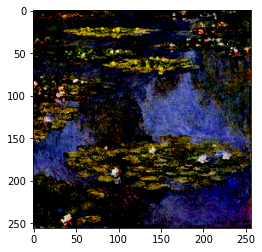

In [4]:
import matplotlib.pyplot as plt
for photo, pic in (dataloader):
    plt.imshow(pic[0].numpy().transpose((1, 2, 0)))
    break
    



In [5]:
for photo, pic in (dataloader):
    cur_batch_size = len(photo)
    print(photo.shape)
    photo = photo.view(cur_batch_size, -1)
    print(photo.shape)
    break
    

torch.Size([128, 3, 256, 256])
torch.Size([128, 196608])


In [6]:
#basic gan only takes 1D Vectors
#this is it's dimension
flatten_dim = 256*256*3

In [7]:
def get_generator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )



In [8]:
class Generator(nn.Module):

    def __init__(self, im_dim=flatten_dim, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            #in flattened image of dimension 3*(256**2) out 128
            get_generator_block(im_dim, hidden_dim), 
            #in 128 out 256
            get_generator_block(hidden_dim, hidden_dim * 2), 
            #in 256 out 512
            get_generator_block(hidden_dim * 2, hidden_dim * 4), 
            #in 512 out 1024
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            #in 1024, out flattened image
            nn.Linear(hidden_dim*8, im_dim), 
            #scale pixel intensities to between 0 and 1
            nn.Sigmoid() 
        )
    def forward(self, image):

        
        return self.gen(image)

In [9]:
def get_discriminator_block(input_dim, output_dim):

    return nn.Sequential(
         nn.Linear(input_dim, output_dim),
         nn.LeakyReLU(0.2, inplace=True)
    )

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, im_dim=flatten_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
            #could add sigmoid here, but we'll have it in the scoring
        )

    def forward(self, image):

        return self.disc(image)

In [11]:
criterion = nn.BCEWithLogitsLoss() 
n_epochs = 700
display_step = 500 
lr = 0.00001
#choose gpu
device = 'cuda'

In [12]:
#get the generator
gen = Generator(im_dim = flatten_dim, hidden_dim = 128).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

#get the discriminator
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)



In [13]:
def get_disc_loss(gen, disc, criterion, photo, num_images, monet, device):

    fake = gen(photo)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(monet)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [14]:
def get_gen_loss(gen, disc, criterion, num_images, photos, device):

    fake = gen(photos)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [15]:
def show_tensor_images(image_tensor, num_images=5, size=(3, 256, 256)):

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(figsize = (20, 10))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()



Step 500: Generator loss: 4.031991370201112, discriminator loss: 0.06424935487285247
Mean loss: 2.048120362536982


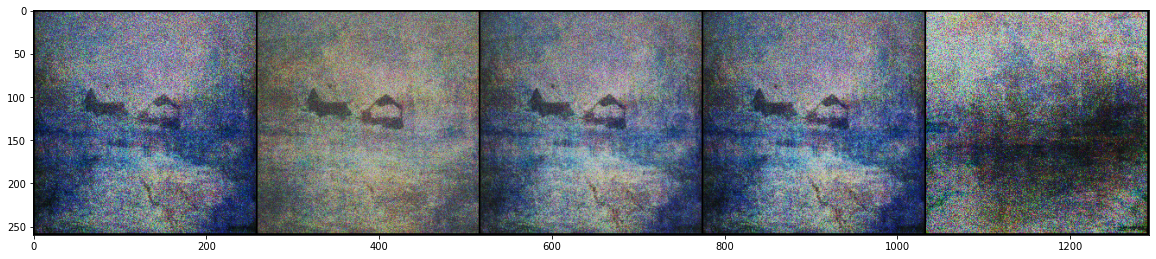

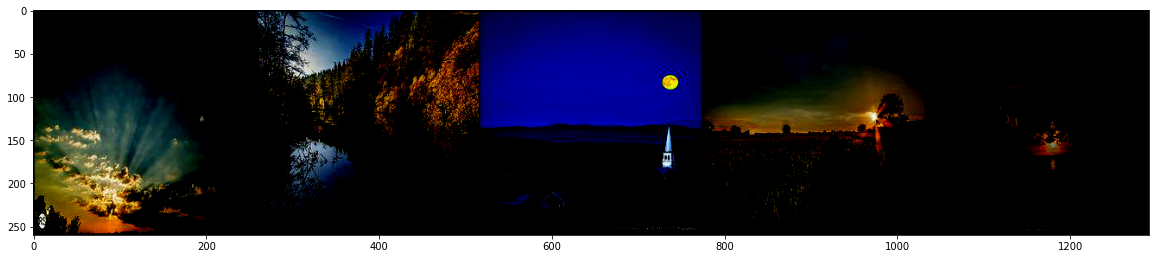

Step 1000: Generator loss: 4.536463043212887, discriminator loss: 0.025977287067100438
Mean loss: 2.2812201651399935


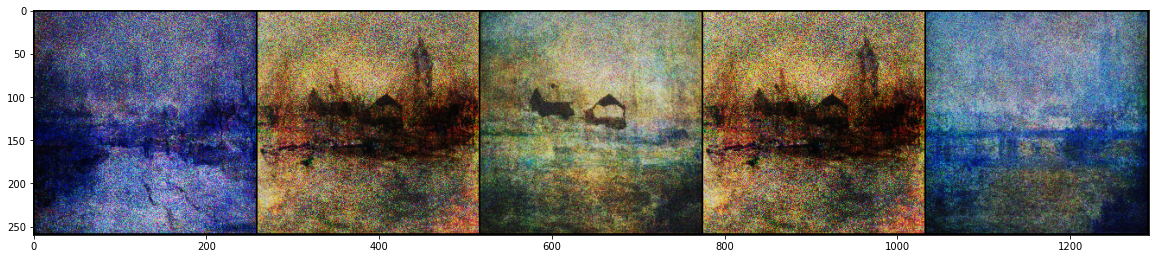

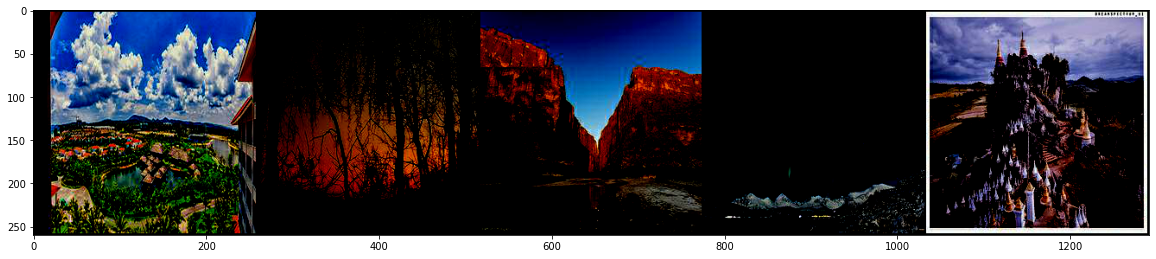

Step 1500: Generator loss: 4.464897889614106, discriminator loss: 0.02389195897243917
Mean loss: 2.2443949242932724


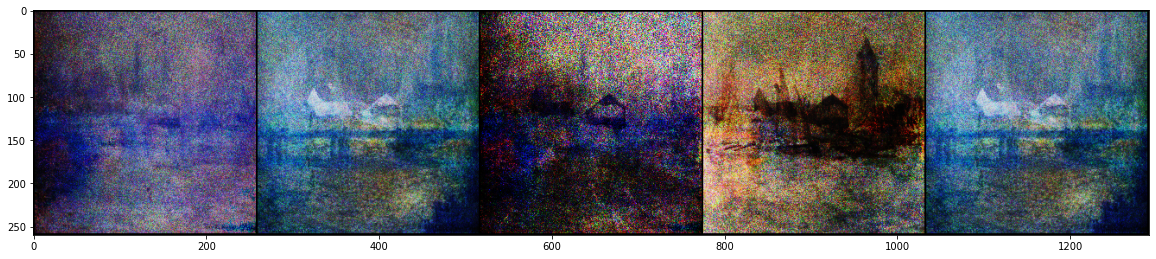

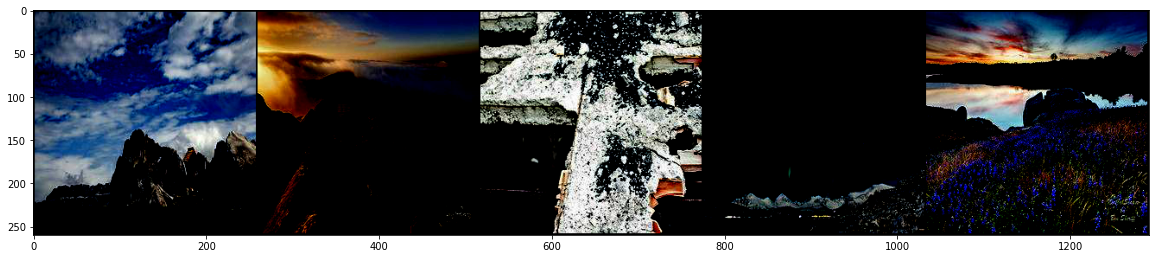

Step 2000: Generator loss: 4.834059171676642, discriminator loss: 0.017098796288482824
Mean loss: 2.4255789839825623


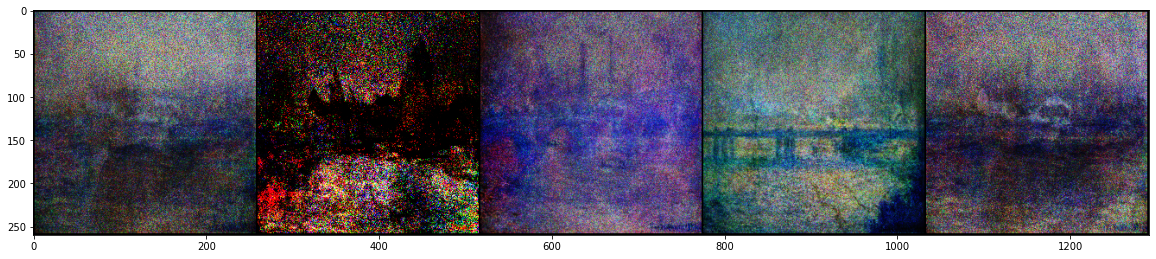

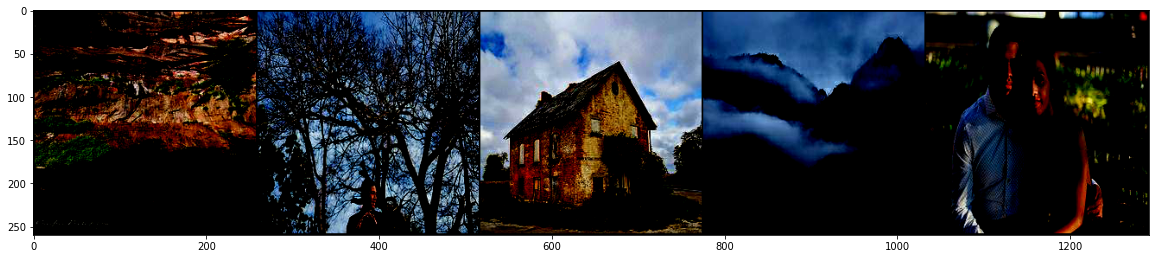

In [16]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for photo, monet in dataloader:
        cur_batch_size = len(photo)

        # Flatten the batch of real images from the dataset
        photo = photo.view(cur_batch_size, -1).to(device)
        monet = monet.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, photo, cur_batch_size, monet, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()
        
        #backpropagation
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, photo, device)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        #show images every display_step
        if cur_step % display_step == 0 and cur_step > 0:
            mean_loss = (mean_generator_loss + mean_discriminator_loss)/2
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            print(f"Mean loss: {mean_loss}")
            fake = gen(photo)
            show_tensor_images(fake)
            show_tensor_images(photo)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [17]:
photo_dataset = PhotoDataset('../input/gan-getting-started/photo_jpg/')
dataloader = DataLoader(photo_dataset, batch_size=1, pin_memory=True)
!mkdir ../images


In [18]:
photo_dataset.__len__()

7038

In [19]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [20]:
topil = transforms.ToPILImage()

In [21]:
t = tqdm(dataloader, leave=False, total=dataloader.__len__())
gen.eval()
for i, photo in enumerate(t):
    with torch.no_grad():
        photo = photo.view(1, -1).to(device)
        pred_monet = gen(photo.to(device)).detach()
    pred_monet = unnorm(pred_monet) #I don't think this is necessary
    pred_monet = torch.reshape(pred_monet, (3, 256, 256))
    img = topil(pred_monet)
    #print(type(img))
    img = img.convert("RGB")
    img.save("../images/" + str(i+1) + ".jpg")

  0%|          | 0/7038 [00:00<?, ?it/s]

In [22]:
b = topil(pred_monet)

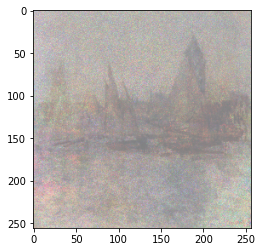

In [23]:
plt.imshow(b)

In [24]:
np.array(b).shape

(256, 256, 3)

In [25]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")



'/kaggle/working/images.zip'

In [26]:
#save models
torch.save(gen.state_dict(), 'generator')
torch.save(disc.state_dict(), 'discriminator')

